<a href="https://colab.research.google.com/github/kaburia/NOAA-workshop/blob/main/03_Temperature_Quality_PET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus Area 3 — Temperature Quality &amp; Microclimates
**Core Objective**: To demonstrate the advantages of high-resolution temperature data in
capturing microclimates and computing derived metrics like PET, for better assessment of heat-
related risks.

## Extract Temperature data
- GHCN data
- CBAM data
- ERA5 data
<br>

EA: March 2025 heatwave, linking to health impacts.

Use the current location and get the nearest GHCNd weather station and visualise the temperature over the last half a century

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>Latitude</th>
            <th>Longitude</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

In [1]:
!git clone https://github.com/kaburia/NOAA-workshop.git
!cd NOAA-workshop && pip install -r requirements.txt

Cloning into 'NOAA-workshop'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 139 (delta 2), reused 0 (delta 0), pack-reused 136 (from 1)
Receiving objects: 100% (139/139), 38.20 MiB | 23.17 MiB/s, done.
Resolving deltas: 100% (67/67), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
import os
os.chdir('NOAA-workshop')

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import json
import ee


In [2]:
from utils.GHCN_stations import subset_stations_in_bbox, get_nearest_wmo_station # GHCN station helper functions
from utils.filter_stations import RetrieveData
from utils.CBAM_helpers import CBAMClient, extract_cbam_data # CBAM helper functions


Root dir: d:\previous-pc\Agent\TAHMO\workshops
Curr dir: d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
eac_region = [[28.861754, -2.8399383],
 [28.861754, -2.8399383],
 [28.861754, -1.0473752],
 [29.573433, -1.4823178],
 [29.573433, -1.4823178],
 [29.573433, 4.218628],
 [30.8991179, -2.8399383],
 [30.8991179, -1.0473752],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, 5.033420899999999],
 [35.0330489, -1.4823178],
 [35.0330489, 4.218628],
 [41.9068688, -4.724299999999999],
 [41.9068688, 5.033420899999999]]

start_date = "2025-04-01"
end_date = "2025-05-31"

ee.Authenticate()
ee.Initialize(project='leafy-computing-310902')

# get the xmin, xmax, ymin, ymax from eac region
def xmin_ymin_xmax_ymax(polygon):
    lons = [point[0] for point in polygon]
    lats = [point[1] for point in polygon]
    return min(lons), min(lats), max(lons), max(lats)
xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(eac_region)
print(xmin, ymin, xmax, ymax)   

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


28.861754 -4.724299999999999 41.9068688 5.033420899999999


We are going to examine the March 2025 heatwave


In [14]:
# Station comparison
start_date = '2024-03-01'
end_date = '2024-03-31'

Extract the TAHMO temperature 5 minute data for 2024 and extrat the tmin, tavg and tmax

In [15]:
# Load TAHMO EAC stations previously extracted
eac_metadata = pd.read_csv("/content/drive/MyDrive/Datasets/ground/eac_stations.csv")
eac_metadata = eac_metadata[['code',
                             'location.latitude',
                             'location.longitude']].rename(columns={'location.latitude': 'lat',
                                                                    'location.longitude': 'lon'})

In [26]:
# Load the config file
with open('/content/config (1).json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)


# Get the temperature data for the EAC stations in 5min intervals
eac_temp = rd.multiple_measurements(stations_list=eac_metadata['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['te'],
                                     csv_file = "/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_temp_march_2024",
                                     aggregate='5min'
                                     )

Retrieving data for stations:   0%|          | 0/260 [00:00<?, ?it/s]

In [25]:
eac_temp

In [22]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [18]:
from google.colab import output
output.disable_custom_widget_manager()

In [27]:
# Aggregate the values to get the min, mean and max for the day
tahmo_eac_tmin = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='min'
)
tahmo_eac_tavg = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='mean'
)
tahmo_eac_tmax = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='max'
)


In [28]:
# Save the variables
tahmo_eac_tmin.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmin_march_2024.csv", index=True)
tahmo_eac_tavg.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tavg_march_2024.csv", index=True)
tahmo_eac_tmax.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmax_march_2024.csv", index=True)

Randomly selected station: TA00141


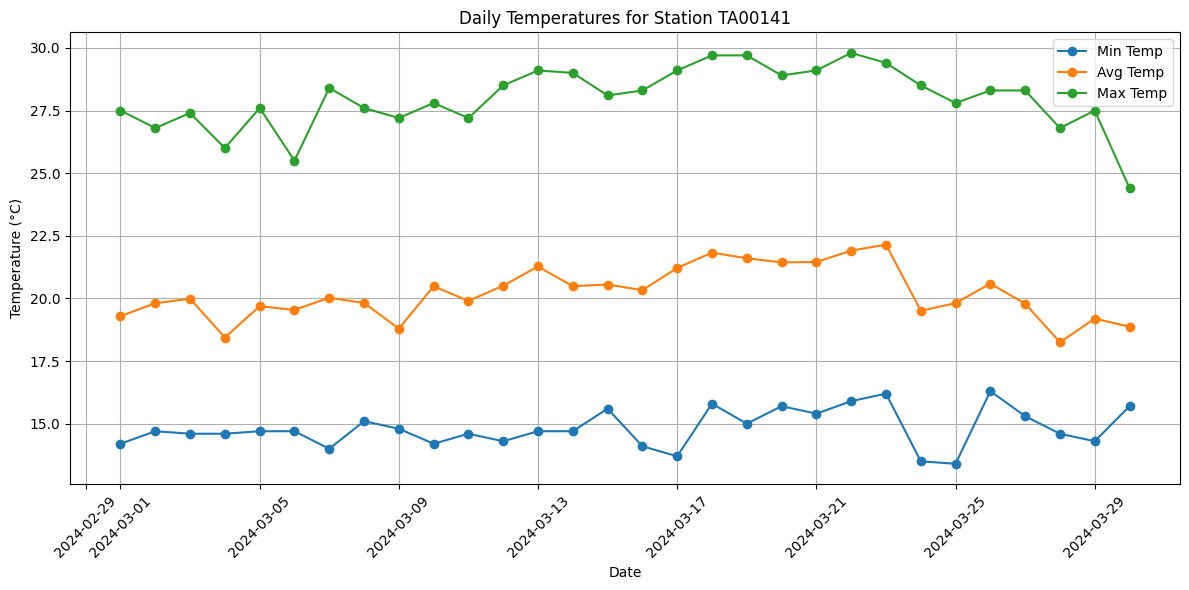

In [55]:
import random

def plot_temperatures(tmin_df, tavg_df, tmax_df, station_code=None):
    """
    Plots the daily minimum, average, and maximum temperatures for a specified TAHMO station.

    Args:
        tmin_df (pd.DataFrame): DataFrame containing daily minimum temperatures.
        tavg_df (pd.DataFrame): DataFrame containing daily average temperatures.
        tmax_df (pd.DataFrame): DataFrame containing daily maximum temperatures.
        station_code (str, optional): The code of the station to plot. If None, a random station from the DataFrame is plotted.
    """
    if station_code is None:
        station_code = random.choice(tmin_df.columns.tolist())
        print(f"Randomly selected station: {station_code}")
    elif station_code not in tmin_df.columns:
        print(f"Station code {station_code} not found in the data.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(tmin_df.index, tmin_df[station_code], label='Min Temp', marker='o', linestyle='-')
    plt.plot(tavg_df.index, tavg_df[station_code], label='Avg Temp', marker='o', linestyle='-')
    plt.plot(tmax_df.index, tmax_df[station_code], label='Max Temp', marker='o', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Daily Temperatures for Station {station_code}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_temperatures(tahmo_eac_tmin, tahmo_eac_tavg, tahmo_eac_tmax)

### GHCNd stations
- Available globally

In [56]:
!git clone https://github.com/scotthosking/get-station-data.git

Cloning into 'get-station-data'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 381 (delta 54), reused 54 (delta 47), pack-reused 287 (from 1)
Receiving objects: 100% (381/381), 1.06 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [59]:
import sys

sys.path.append('get-station-data')

from get_station_data import ghcnd
from get_station_data.util import nearest_stn

%matplotlib inline

In [62]:
stn_md = ghcnd.get_stn_metadata()
# stn_md

# Format the data rename lat and lon to latitude and longitude
stn_md = stn_md.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

In [68]:
# Nairobi coordinates
nairobi_coords = (-1.2921, 36.8219)


In [ ]:
# Get the nearest station

#### Compare the temperature of TAHMO station/WMO station with the Met Agency data

In [65]:
# Compare the temperatures

### Extract CBAM temperature data (2012 -2024)

In [ ]:
# Define parameters as shown in the docs
product = 'cbam_historical_analysis'
attribs = ["max_temperature", "min_temperature"]
# start_date = '2012-01-01'
# end_date = '2023-12-31'
eac_bbox = [xmin, ymin, xmax, ymax]
print(eac_bbox)

# Create a client and extract data
client = CBAMClient('config.json')
cbam_data = extract_cbam_data(start_date='2012-01-01', end_date='2024-12-31',
                         attributes=attribs, cbam_client=client, bbox=eac_bbox,
                         output_type='netcdf')


[28.861754, -4.724299999999999, 41.9068688, 5.033420899999999]


### Extract ERA5 temperature data (1980-2025)

## Data Processing

1. Ground (GHCN/TAHMO/your station) vs CBAM/ERA5
2. PET comparison plot (CBAM vs ERA5)
3. Count of heat/agri stress days --- Plot of the heat exchange